# AGS-GNN Graph Sampling

In [2]:
import sys
sys.path.append('../Submodular')

import DeviceDir

DIR, RESULTS_DIR = DeviceDir.get_directory()
device, NUM_PROCESSORS = DeviceDir.get_device()

In [3]:
from ipynb.fs.full.Dataset import get_data
from ipynb.fs.full.Dataset import datasets as available_datasets
from ipynb.fs.full.Utils import save_plot

In [4]:
import argparse
from argparse import ArgumentParser

#set default arguments here
def get_configuration():
    parser = ArgumentParser()
    parser.add_argument('--epochs', type=int, default=1)
    parser.add_argument('--log_info', type=bool, default=True)
    parser.add_argument('--pbar', type=bool, default=False)
    parser.add_argument('--batch_size', type=int, default=2048)
    parser.add_argument('--learning_rate', type=float, default=0.01)
    parser.add_argument('--num_gpus', type=int, default=-1)
    parser.add_argument('--parallel_mode', type=str, default="dp", choices=['dp', 'ddp', 'ddp2'])
    parser.add_argument('--dataset', type=str, default="Cora", choices=available_datasets)
    parser.add_argument('--use_normalization', action='store_false', default=True)
    parser.add_argument('-f') ##dummy for jupyternotebook
    args = parser.parse_args()
    
    dict_args = vars(args)
    
    return args, dict_args

args, dict_args = get_configuration()

In [5]:
import random
import numpy as np
import torch

seed = 123

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
None

## GNN model

In [6]:
import os
import math
import time
import torch_geometric
from torch_geometric.data import Data, Dataset
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, GINConv, ChebConv
from torch_geometric.nn import GraphConv, TransformerConv
from torch_geometric.utils import degree
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from ipynb.fs.full.SpatialConv import SpatialConv
from tqdm import tqdm
import torch.nn as nn

## Homophilic GNN

In [7]:
class HomophilicNet(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden_channels, end_hidden):
        super().__init__()
        in_channels = num_features
        out_channels = num_classes
        self.conv1 = GraphConv(in_channels, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
#         self.conv3 = GraphConv(hidden_channels, hidden_channels)
#         self.lin = torch.nn.Linear(3 * hidden_channels, end_hidden)
#         self.lin2 = torch.nn.Linear(3 * hidden_channels, out_channels)
        self.lin = torch.nn.Linear(2 * hidden_channels, end_hidden)
        self.lin2 = torch.nn.Linear(2 * hidden_channels, out_channels)


    def set_aggr(self, aggr):
        self.conv1.aggr = aggr
        self.conv2.aggr = aggr
#         self.conv3.aggr = aggr

    def forward(self, x0, edge_index, edge_weight=None):
        x1 = F.relu(self.conv1(x0, edge_index, edge_weight))
        x1 = F.dropout(x1, p=0.2, training=self.training)
        x2 = F.relu(self.conv2(x1, edge_index, edge_weight))
        x2 = F.dropout(x2, p=0.2, training=self.training)
#         x3 = F.relu(self.conv3(x2, edge_index, edge_weight))
#         x3 = F.dropout(x3, p=0.2, training=self.training)
#         x = torch.cat([x1, x2, x3], dim=-1)

        x = torch.cat([x1, x2], dim=-1)
        
        c1 = self.lin(x)
        c2 = self.lin2(x)
        
        return F.relu(c1), c2.log_softmax(dim=-1)

## Heterophilic GNN

In [8]:
#replace this part with ACMGCN
#import ACM.modelgeom.layers as layers
from ACM.modelgeom.models import GCN
import scipy.sparse as sp
from torch_geometric.utils.convert import to_scipy_sparse_matrix
from ipynb.fs.full.ACM.models.Test import normalize_tensor, sparse_mx_to_torch_sparse_tensor

In [9]:
class HeterophilicNet(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden_channels, end_hidden, N):
        super().__init__()
        in_channels = num_features
        out_channels = num_classes
                
        self.hetero_gnn  = GCN(
            nfeat=num_features,
            nhid=hidden_channels,
            nclass=hidden_channels,
            nlayers=2,
            nnodes=N,
            dropout=0.2,
            model_type='acmgcnp',
            structure_info=1,
            variant=True,)
        
        self.lin = torch.nn.Linear(hidden_channels, end_hidden)
        self.lin2 = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, batch_data):
                
        n = batch_data.num_nodes
        x = batch_data.x
        
        #print(batch_data)
        
        edge_index, _ = torch_geometric.utils.add_self_loops(batch_data.edge_index, num_nodes=n)
        
        adj_low_unnormalized = to_scipy_sparse_matrix(edge_index)
        
#         print(sp.identity(n).shape)
#         print(adj_low_unnormalized.shape)
        
        
        adj_low = normalize_tensor(sp.identity(n) + adj_low_unnormalized)
        adj_high = sp.identity(n) - adj_low
        adj_low = sparse_mx_to_torch_sparse_tensor(adj_low).to(device)
        adj_high = sparse_mx_to_torch_sparse_tensor(adj_high).to(device)
        adj_low_unnormalized = sparse_mx_to_torch_sparse_tensor(adj_low_unnormalized).to(device)

#         print(x.device, adj_low.device, adj_high.device, adj_low_unnormalized.device)
        
        x = self.hetero_gnn(x, adj_low, adj_high, adj_low_unnormalized)
        
        c1 = self.lin(x)
        c2 = self.lin2(x)
        
        return F.relu(c1), c2.log_softmax(dim=-1)

## Combination Network

In [10]:
class AGSGNN(torch.nn.Module):
    def __init__(self, num_features,num_classes, hidden_channels=256, dropout=0.5, N = 0):
        super().__init__()
        self.num_classes = num_classes
        
        hidden = int(hidden_channels/2)        
        self.gnn1 = HomophilicNet(num_features, num_classes, hidden_channels, hidden)
        self.gnn2 = HeterophilicNet(num_features, num_classes, hidden_channels, hidden, N = N)
        self.p = dropout
        self.com_lin = nn.Linear(hidden*2, num_classes)      
        
    def forward(self, batch_data):
        
        #out = model(batch_data.x, batch_data.edge_index, batch_data.edge_weight)
        #out = model(batch_data.x, batch_data.edge_index)
        
        x1, x1c1 = self.gnn1(batch_data[0].x, batch_data[0].edge_index, batch_data[0].weight)
        x2, x2c2 = self.gnn2(batch_data[1])

#         x1 = self.gnn1(batch_data[0].x, batch_data[0].edge_index)
#         x2 = self.gnn2(batch_data[1].x, batch_data[1].edge_index)

        a1 = F.relu(x1)
        a1 = F.dropout(a1, p=self.p, training=self.training)
        
        s1 = F.relu(x2)        
        s1 = F.dropout(s1, p=self.p, training=self.training)
        
        batch_size = batch_data[0].batch_size        
        x = torch.cat([a1[:batch_size,:], s1[:batch_size,:]], dim=-1)
        x = self.com_lin(x)
        
        #return x
    
        return x.log_softmax(dim=-1), x1c1, x2c2

## GNN Training and Testing

In [11]:
from ipynb.fs.full.a2AGS_Graph_Sampler import AGSGraphSampler
from torch_geometric.loader import NeighborSampler, NeighborLoader

In [12]:
from collections import Counter
import random

def prediction(y_pred_seed, y_pred_hm, y_pred_ht):
    
    all_tensors = [y_pred_seed, y_pred_hm, y_pred_ht]
    final_predictions = []

    for i in range(len(y_pred_seed)):
        values_at_index = [tensor[i].item() for tensor in all_tensors]
        counter = Counter(values_at_index)
        most_common_values = counter.most_common()

        # Check if there's a tie
        if len(most_common_values) > 1 and most_common_values[0][1] == most_common_values[1][1]:
            #selected_value = random.choice([value for value, count in most_common_values[:2]])
            selected_value = y_pred_seed[i].item()
        else:
            selected_value = most_common_values[0][0]

        final_predictions.append(selected_value)
            
    return torch.LongTensor(final_predictions)

y_pred_seed = torch.tensor([0, 1, 2, 2, 1])
y_pred_hm = torch.tensor([2, 1, 1, 0, 2])
y_pred_ht = torch.tensor([0, 2, 1, 1, 0])


# prediction(y_pred_seed,y_pred_hm,y_pred_ht)

In [13]:
def test(model, loader, mask, name='Train', channel='all'):
    if args.log_info:
        pbar = tqdm(total=sum(mask).item())
        pbar.set_description(f'Evaluating {name}')

    model.eval()
    
    total_correct=0
    total_examples=0
    
    with torch.no_grad():                  
    
        for i,batch_data in enumerate(loader):
            
            batch_data = [b_data.to(device) for b_data in batch_data]
            batch_size = batch_data[0].batch_size
            batch_data[0].weight = batch_data[0].edge_norm * batch_data[0].edge_weight
            
            out, out1, out2 = model(batch_data)
                
            #print(out.shape, out1.shape, out2.shape)
            
            y_pred_seed = out[:batch_size].argmax(dim=-1).cpu()
            y_pred_hm = out1[:batch_size].argmax(dim=-1).cpu()
            y_pred_ht = out2[:batch_size].argmax(dim=-1).cpu()
            
            #print(y_pred_seed.shape,y_pred_hm.shape, y_pred_ht.shape)
            
            
            y_true = batch_data[0].y[:batch_size]
            
            if name == 'Train':
                t_mask = batch_data[0].train_mask[:batch_size]
            elif name == 'Validation':
                t_mask = batch_data[0].val_mask[:batch_size]
            else:
                t_mask = batch_data[0].test_mask[:batch_size]

            if channel=='sd':
                y_pred = y_pred_seed
            elif channel=='hm':
                y_pred = y_pred_hm
            elif channel=='ht':
                y_pred = y_pred_ht
            else:
                y_pred = prediction(y_pred_seed, y_pred_hm, y_pred_ht)

            #print(y_pred)                
            correct = y_pred.eq(y_true.cpu())
            total_correct+= correct[t_mask].sum().item()
            items = t_mask.sum().item()
            total_examples+= items           
            if args.log_info:
                pbar.update(items)
    
    if args.log_info:
        pbar.close()

    return total_correct/total_examples


In [14]:
#https://github.com/GraphSAINT/GraphSAINT/issues/11
    
def train(DATASET_NAME,model, data, dataset, epochs=1, channel='all', BATCH_SIZE=1024): #'all', 'hm', 'ht', 'sd'
        
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)    
    if data.y.ndim == 1:
        criterion = torch.nn.CrossEntropyLoss() #regular logits as output
#         criterion = torch.nn.NLLLoss() ## if log softmax used as activation
    else:
        criterion = torch.nn.BCEWithLogitsLoss()     #multillabel
    
    row, col = data.edge_index
    data.edge_weight = 1. / degree(col, data.num_nodes)[col]  # Norm by in-degree.
    
    #minibatch_size= 2048
    minibatch_size = BATCH_SIZE
    
    sampler_dir = DIR+'AGSGSAINTACM/'+DATASET_NAME
    if not os.path.exists(sampler_dir):
        os.makedirs(sampler_dir)
        
    #batch_size= min(1024, data.num_nodes)
    #num_steps=math.ceil(sum (data.train_mask)/batch_size)    
    num_steps=math.ceil(data.num_nodes/minibatch_size)
    num_workers = 8  if data.num_nodes>50000 else 0
    
    
    sample_func =['rw', 'rw']
    weight_func =[
        {'exact':False,'weight':'random'}, #exact for exact size to the batch
        {'exact':True,'weight':'random'}
    ]

    params={'knn':{'metric':'cosine'},
            'submodular':{'metric':'cosine'},
            'link-nn':{'value':'min'},
            'link-sub':{'value':'max'},
            'disjoint':{'value':'mst'},
           }
    
    loader = AGSGraphSampler(
        data, batch_size=minibatch_size, walk_length=2, num_steps=num_steps, sample_coverage=100,
        num_workers=num_workers,log=args.log_info,save_dir=sampler_dir,recompute = False, shuffle = False,
        sample_func = sample_func, weight_func=weight_func, params=params)
        
    
    #for evaluation
    train_num_steps = int(torch.ceil(sum(data.train_mask)/minibatch_size))
    val_num_steps = int(torch.ceil(sum(data.val_mask)/minibatch_size))
    test_num_steps = int(torch.ceil(sum(data.test_mask)/minibatch_size))
    
    train_loader = AGSGraphSampler(
        data, input_nodes = data.train_mask, batch_size=minibatch_size, walk_length=2, num_steps=train_num_steps, 
        sample_coverage=100,num_workers=num_workers,log=args.log_info,save_dir=sampler_dir,
        recompute = False, shuffle = False,sample_func = sample_func, weight_func=weight_func, params=params)
    
    
    val_loader = AGSGraphSampler(
        data, input_nodes = data.val_mask, batch_size=minibatch_size, walk_length=2, num_steps=val_num_steps, 
        sample_coverage=100,num_workers=num_workers,log=args.log_info,save_dir=sampler_dir,
        recompute = False, shuffle = False,sample_func = sample_func, weight_func=weight_func, params=params)
        
    test_loader = AGSGraphSampler(
        data, input_nodes = data.test_mask, batch_size=minibatch_size, walk_length=2, num_steps=test_num_steps, 
        sample_coverage=100,num_workers=num_workers,log=args.log_info,save_dir=sampler_dir,
        recompute = False, shuffle = False,sample_func = sample_func, weight_func=weight_func, params=params)
            
            
    best_acc=0    
    train_losses = []; val_accuracies = []; train_accuracies = []; test_accuracies = []    
    max_iteration = epochs    
    
    
    th_node = 10000
    
    if (minibatch_size == data.num_nodes) and data.num_nodes<th_node:
        test_data = data.clone()
        test_data.weight = loader.edge_norm * test_data.edge_weight
        test_data.seed_node=torch.arange(test_data.num_nodes)  
        test_data.batch_size=test_data.seed_node.shape[0]
        all_data = [test_data.to(device), test_data.to(device)]    
        
        if args.log_info:
            print(all_data)
            
    for epoch in range(1,epochs+1):
        
        if args.log_info:
            pbar = tqdm(total=num_steps)
            pbar.set_description(f'Epoch {epoch:02d}')
        
        model.train()
        #if model.__class__.__name__ == 'Net':
            #model.set_aggr('add' if args.use_normalization else 'mean')
        model.gnn1.set_aggr('add' if args.use_normalization else 'mean')
        #model.gnn2.set_aggr('add' if args.use_normalization else 'mean')

        total_loss = total_examples = 0
        total_loss_seed = total_loss_hm = total_loss_ht = 0
        total_seed_example = total_hm_example = total_ht_example = 0
                    
        for i,batch_data in enumerate(loader):
            
#             print(batch_data);
#             print("*"*50)            
            
            batch_data = [b_data.to(device) for b_data in batch_data]
            batch_size = batch_data[0].batch_size
            mask = batch_data[0].train_mask[:batch_size]
            y_true = batch_data[0].y[:batch_size]
            
            if torch.sum(mask) == 0:
                print("no training mask in seed node")
#                 continue

            optimizer.zero_grad()
            if args.use_normalization:                 
                
                batch_data[0].weight = batch_data[0].edge_norm * batch_data[0].edge_weight
                batch_data[1].weight = batch_data[1].edge_norm * batch_data[1].edge_weight
                
                out, out1, out2 = model(batch_data)                            
                #print(out.shape, out1.shape, out2.shape)
                
                                
#                 print(out[:batch_size][mask].shape, y_true[mask].shape)                
#                 print(loss.shape)
#                 print(batch_data[0].node_norm.shape)
#                 print(batch_data[0].node_norm[:batch_size].shape)
#                 loss = criterion(out, batch_data.y, reduction='none')

                #--------- loss computation seed nodes --------- #                
                loss_seed = F.nll_loss(out[:batch_size][mask], y_true[mask], reduction='none')
                loss_seed = (loss_seed * batch_data[0].node_norm[:batch_size][mask]).sum()
        
                #--------- loss computation homophily nodes --------- #
            
                loss_hm = F.nll_loss(out1[batch_data[0].train_mask], batch_data[0].y[batch_data[0].train_mask], reduction='none')
                loss_hm = (loss_hm * batch_data[0].node_norm[batch_data[0].train_mask]).sum()
                
                #--------- loss computation homophily nodes --------- #
                loss_ht = F.nll_loss(out2[batch_data[1].train_mask], batch_data[1].y[batch_data[1].train_mask], reduction='none')
                loss_ht = (loss_ht * batch_data[1].node_norm[batch_data[1].train_mask]).sum()
                
                if channel=='sd':loss = loss_seed
                elif channel=='hm':loss = loss_hm
                elif channel=='ht':loss = loss_ht
                else:loss = loss_seed + loss_hm + loss_ht                

            else:
                batch_data[0].weight = None
                batch_data[1].weight = None
                    
                out, out1, out2 = model(batch_data)                            
                #print(out.shape, out1.shape, out2.shape)
                
                mask = batch_data[0].train_mask[:batch_size]
                y_true = batch_data[0].y[:batch_size]
                
                #--------- loss computation seed nodes --------- #                
                loss_seed = F.nll_loss(out[:batch_size][mask], y_true[mask])
                
                #--------- loss computation homophily nodes --------- #
                loss_hm = F.nll_loss(out1[batch_data[0].train_mask], batch_data[0].y[batch_data[0].train_mask])
                
                #--------- loss computation homophily nodes --------- #
                loss_ht = F.nll_loss(out2[batch_data[1].train_mask], batch_data[1].y[batch_data[1].train_mask])
                #loss = criterion(out[batch_data.train_mask], batch_data.y[batch_data.train_mask])
                
                if channel=='sd':loss = loss_seed
                elif channel=='hm':loss = loss_hm
                elif channel=='ht':loss = loss_ht
                else:loss = loss_seed + loss_hm + loss_ht
                                                        
            loss.backward()
            optimizer.step()
            
            total_loss_seed+= loss_seed.item()*batch_size
            total_loss_hm+= loss_hm.item()*sum(batch_data[0].train_mask).item()
            total_loss_ht+= loss_ht.item()*sum(batch_data[1].train_mask).item()
            
            total_seed_example+= sum(mask).item()
            total_hm_example+=sum(batch_data[0].train_mask).item()
            total_ht_example+=sum(batch_data[1].train_mask).item()
            
            if args.log_info:
                pbar.update(1)
        
        if args.log_info:
            pbar.close()
            
        total_loss_seed /= max(total_seed_example,1)
        total_loss_hm /= max(total_hm_example,1)
        total_loss_ht /= max(total_ht_example,1)
        
        total_loss=total_loss_seed+total_loss_hm+total_loss_ht
        total_examples = total_seed_example + total_hm_example + total_ht_example
        
        if args.log_info:
            print(f'Loss:{total_loss:0.4f} seed:{total_loss_seed:0.4f} hm:{total_loss_hm:0.4f} ht:{total_loss_ht:0.4f}')
            print(f'Example:{total_examples:1d} seed:{total_seed_example:1d} hm:{total_hm_example:1d} ht:{total_ht_example:1d}')
        
        if channel=='sd':train_losses.append(total_loss_seed)
        elif channel=='hm':train_losses.append(total_loss_hm)
        elif channel=='ht':train_losses.append(total_loss_ht)
        else:train_losses.append(total_loss)
                        

        model.eval()       
        model.gnn1.set_aggr('add' if args.use_normalization else 'mean')
#         model.gnn2.set_aggr('add' if args.use_normalization else 'mean')
        accs = [0,0,0]
        
        if (minibatch_size == data.num_nodes) and data.num_nodes<th_node:
                        
            with torch.no_grad():
                out, out1, out2 = model(all_data)
                
                #print(out.shape, out1.shape, out2.shape)
                y_pred_seed = out.argmax(dim=-1).cpu()
                y_pred_hm = out1.argmax(dim=-1).cpu()
                y_pred_ht = out2.argmax(dim=-1).cpu()
                
                if channel=='sd':
                    y_pred = y_pred_seed
                elif channel=='hm':
                    y_pred = y_pred_hm
                elif channel=='ht':
                    y_pred = y_pred_ht
                else:
                    y_pred = prediction(y_pred_seed, y_pred_hm, y_pred_ht)
                
                #print(y_pred)                
                correct = y_pred.eq(data.y.cpu())
                accs = []
                for _, mask in data('train_mask', 'val_mask', 'test_mask'):
                    accs.append(correct[mask].sum().item() / mask.sum().item()) 
                                                    
        else:
            accs[0] = test(model, train_loader, data.train_mask, name='Train',channel=channel)
            accs[1] = test(model, val_loader, data.val_mask, name='Validation',channel=channel)
            accs[2] = test(model, test_loader, data.test_mask, name='Test',channel=channel)
            
        train_accuracies.append(accs[0])
        val_accuracies.append(accs[1])
        test_accuracies.append(accs[2])
        std_dev = np.std(train_losses[-5:])
        
        if args.log_info:
            print(f'Epoch: {epoch:03d}, Train Loss: {loss:.4f}, Train: {accs[0]:.4f}, Val: {accs[1]:.4f}, Test: {accs[2]:.4f}, Std dev: {std_dev:.4f}')
        
        if epoch>=5 and std_dev<=1e-3:
            if args.log_info:
                print("Iteration for convergence: ", epoch)
            max_iteration = epoch
            break
    
    if args.log_info:
        save_plot([train_losses, train_accuracies, val_accuracies, test_accuracies], labels=['Loss','Train','Validation','Test'], name='Results/AGSGSValidation', yname='Accuracy', xname='Epoch')
        print ("Best Validation Accuracy, ",max(val_accuracies))
        print ("Best Test Accuracy, ",max(test_accuracies))
    
    if (minibatch_size == data.num_nodes) and data.num_nodes<th_node:
        del all_data
    
    return max(test_accuracies), max_iteration

In [15]:
def AGSGSperformanceSampler(DATASET_NAME,data, dataset, num_classes, epochs=1,channel='all'):
    
    ###
    BATCH_SIZE = min(data.num_nodes, 1024)
    
    if args.log_info:
        print("BATCH SIZE: ", BATCH_SIZE)
        
    model = AGSGNN(data.x.shape[1], num_classes, hidden_channels=256, N = BATCH_SIZE).to(device)            
    
    if args.log_info:
        print(model)
    
    itr, accuracy = train(DATASET_NAME, model, data, dataset, epochs, channel, BATCH_SIZE)
    
    return itr, accuracy, model

In [16]:
from sklearn.decomposition import TruncatedSVD
import numpy as np

def adj_feature(data):    
    adj_mat = torch.zeros((data.num_nodes,data.num_nodes))
    edges = data.edge_index.t()
    adj_mat[edges[:,0], edges[:,1]] = 1
    adj_mat[edges[:,1], edges[:,0]] = 1
    
#     n_components = data.x.shape[1]
    n_components = min(256, data.x.shape[1], data.num_nodes)

    svd = TruncatedSVD(n_components=n_components)
    x = svd.fit_transform(adj_mat)
    
    x = torch.Tensor(x)
    x.shape    
    
    return x

# x = adj_feature(data)
# x.shape

N  5201  E  217073  d  41.73678138819458 0.08891735225915909 0.2239430993795395 0.042996399104595184 0.3737970292568207 Data(x=[5201, 2089], edge_index=[2, 217073], y=[5201], train_mask=[5201], val_mask=[5201], test_mask=[5201])
BATCH SIZE:  1024
AGSGNN(
  (gnn1): HomophilicNet(
    (conv1): GraphConv(2089, 256)
    (conv2): GraphConv(256, 256)
    (lin): Linear(in_features=512, out_features=128, bias=True)
    (lin2): Linear(in_features=512, out_features=5, bias=True)
  )
  (gnn2): HeterophilicNet(
    (hetero_gnn): GCN(
      (gcns): ModuleList(
        (0): GraphConvolution (2089 -> 256)
        (1): GraphConvolution (256 -> 256)
      )
      (mlps): ModuleList()
    )
    (lin): Linear(in_features=256, out_features=128, bias=True)
    (lin2): Linear(in_features=256, out_features=5, bias=True)
  )
  (com_lin): Linear(in_features=256, out_features=5, bias=True)
)
loading saved norm
loading saved norm
loading saved norm
loading saved norm


Epoch 01: 100%|██████████| 6/6 [00:00<00:00, 15.63it/s]


Loss:2.7367 seed:1.2648 hm:0.8366 ht:0.6353
Example:10240 seed:2654 hm:4649 ht:2937


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 34080.07it/s]


Epoch: 001, Train Loss: 0.6006, Train: 0.2003, Val: 0.2019, Test: 0.1979, Std dev: 0.0000


Epoch 02: 100%|██████████| 6/6 [00:00<00:00, 16.71it/s]


Loss:2.7119 seed:1.2470 hm:0.8387 ht:0.6262
Example:10386 seed:2697 hm:4717 ht:2972


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 31881.29it/s]


Epoch: 002, Train Loss: 0.6279, Train: 0.2007, Val: 0.2007, Test: 0.1979, Std dev: 0.0046


Epoch 03: 100%|██████████| 6/6 [00:00<00:00, 16.58it/s]


Loss:2.7038 seed:1.2671 hm:0.8372 ht:0.5995
Example:10263 seed:2654 hm:4698 ht:2911


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 32325.50it/s]


Epoch: 003, Train Loss: 0.6054, Train: 0.2035, Val: 0.2043, Test: 0.1988, Std dev: 0.0152


Epoch 04: 100%|██████████| 6/6 [00:00<00:00, 14.12it/s]


Loss:2.6693 seed:1.2404 hm:0.8311 ht:0.5978
Example:10314 seed:2681 hm:4678 ht:2955


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 17073.35it/s]


Epoch: 004, Train Loss: 0.6278, Train: 0.2151, Val: 0.2145, Test: 0.2200, Std dev: 0.0164


Epoch 05: 100%|██████████| 6/6 [00:00<00:00, 14.86it/s]


Loss:2.6551 seed:1.2559 hm:0.8254 ht:0.5739
Example:10226 seed:2669 hm:4620 ht:2937


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 26963.27it/s]


Epoch: 005, Train Loss: 0.5654, Train: 0.2841, Val: 0.2620, Test: 0.2469, Std dev: 0.0219


Epoch 06: 100%|██████████| 6/6 [00:00<00:00, 15.65it/s]


Loss:2.6403 seed:1.2642 hm:0.8277 ht:0.5485
Example:10204 seed:2638 hm:4670 ht:2896


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 29787.22it/s]


Epoch: 006, Train Loss: 0.5421, Train: 0.3081, Val: 0.2861, Test: 0.2747, Std dev: 0.0262


Epoch 07: 100%|██████████| 6/6 [00:00<00:00, 14.13it/s]


Loss:2.5962 seed:1.2470 hm:0.8229 ht:0.5263
Example:10198 seed:2634 hm:4673 ht:2891


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 33678.14it/s]


Epoch: 007, Train Loss: 0.5358, Train: 0.3321, Val: 0.2957, Test: 0.2997, Std dev: 0.0284


Epoch 08: 100%|██████████| 6/6 [00:00<00:00, 14.26it/s]


Loss:2.6319 seed:1.2692 hm:0.8395 ht:0.5232
Example:10218 seed:2646 hm:4642 ht:2930


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 16811.45it/s]


Epoch: 008, Train Loss: 0.5290, Train: 0.3646, Val: 0.2975, Test: 0.3180, Std dev: 0.0285


Epoch 09: 100%|██████████| 6/6 [00:00<00:00, 15.60it/s]


Loss:2.6066 seed:1.2592 hm:0.8379 ht:0.5095
Example:10275 seed:2663 hm:4661 ht:2951


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 29621.31it/s]


Epoch: 009, Train Loss: 0.4946, Train: 0.4103, Val: 0.3071, Test: 0.3208, Std dev: 0.0226


Epoch 10: 100%|██████████| 6/6 [00:00<00:00, 14.49it/s]


Loss:2.5690 seed:1.2362 hm:0.8442 ht:0.4886
Example:10519 seed:2740 hm:4753 ht:3026


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 28451.06it/s]


Epoch: 010, Train Loss: 0.5162, Train: 0.4635, Val: 0.3143, Test: 0.3401, Std dev: 0.0198


Epoch 11: 100%|██████████| 6/6 [00:00<00:00, 16.53it/s]


Loss:2.5577 seed:1.2502 hm:0.8402 ht:0.4673
Example:10245 seed:2638 hm:4669 ht:2938


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 29706.36it/s]


Epoch: 011, Train Loss: 0.4490, Train: 0.5048, Val: 0.3269, Test: 0.3391, Std dev: 0.0223


Epoch 12: 100%|██████████| 6/6 [00:00<00:00, 14.04it/s]


Loss:2.5285 seed:1.2659 hm:0.8343 ht:0.4284
Example:10160 seed:2603 hm:4660 ht:2897


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 29387.85it/s]


Epoch: 012, Train Loss: 0.4815, Train: 0.5329, Val: 0.3275, Test: 0.3449, Std dev: 0.0334


Epoch 13: 100%|██████████| 6/6 [00:00<00:00, 15.65it/s]


Loss:2.4820 seed:1.2506 hm:0.8201 ht:0.4114
Example:10174 seed:2645 hm:4597 ht:2932


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 27264.99it/s]


Epoch: 013, Train Loss: 0.3818, Train: 0.5593, Val: 0.3329, Test: 0.3497, Std dev: 0.0366


Epoch 14: 100%|██████████| 6/6 [00:00<00:00, 14.03it/s]


Loss:2.4874 seed:1.2590 hm:0.8363 ht:0.3920
Example:10348 seed:2690 hm:4699 ht:2959


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 28808.86it/s]


Epoch: 014, Train Loss: 0.3599, Train: 0.5805, Val: 0.3305, Test: 0.3535, Std dev: 0.0356


Epoch 15: 100%|██████████| 6/6 [00:00<00:00, 14.56it/s]


Loss:2.4493 seed:1.2557 hm:0.8348 ht:0.3588
Example:10205 seed:2635 hm:4663 ht:2907


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 29591.60it/s]


Epoch: 015, Train Loss: 0.3411, Train: 0.6122, Val: 0.3389, Test: 0.3487, Std dev: 0.0362


Epoch 16: 100%|██████████| 6/6 [00:00<00:00, 13.78it/s]


Loss:2.4000 seed:1.2391 hm:0.8288 ht:0.3320
Example:10338 seed:2701 hm:4641 ht:2996


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 17226.39it/s]


Epoch: 016, Train Loss: 0.3400, Train: 0.6302, Val: 0.3413, Test: 0.3631, Std dev: 0.0350


Epoch 17: 100%|██████████| 6/6 [00:00<00:00, 15.56it/s]


Loss:2.4659 seed:1.2730 hm:0.8536 ht:0.3393
Example:10329 seed:2662 hm:4711 ht:2956


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 36862.96it/s]


Epoch: 017, Train Loss: 0.3616, Train: 0.6518, Val: 0.3377, Test: 0.3641, Std dev: 0.0305


Epoch 18: 100%|██████████| 6/6 [00:00<00:00, 14.22it/s]


Loss:2.4124 seed:1.2600 hm:0.8493 ht:0.3032
Example:10409 seed:2710 hm:4727 ht:2972


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 25736.32it/s]


Epoch: 018, Train Loss: 0.3145, Train: 0.6771, Val: 0.3377, Test: 0.3641, Std dev: 0.0295


Epoch 19: 100%|██████████| 6/6 [00:00<00:00, 15.48it/s]


Loss:2.4041 seed:1.2629 hm:0.8392 ht:0.3019
Example:10322 seed:2686 hm:4680 ht:2956


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 22006.75it/s]


Epoch: 019, Train Loss: 0.3055, Train: 0.6903, Val: 0.3353, Test: 0.3564, Std dev: 0.0218


Epoch 20: 100%|██████████| 6/6 [00:00<00:00, 16.35it/s]


Loss:2.4181 seed:1.2776 hm:0.8635 ht:0.2770
Example:10476 seed:2722 hm:4767 ht:2987


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 35516.61it/s]


Epoch: 020, Train Loss: 0.2620, Train: 0.7083, Val: 0.3480, Test: 0.3449, Std dev: 0.0225


Epoch 21: 100%|██████████| 6/6 [00:00<00:00, 17.41it/s]


Loss:2.3263 seed:1.2379 hm:0.8299 ht:0.2585
Example:10370 seed:2694 hm:4705 ht:2971


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 36949.69it/s]


Epoch: 021, Train Loss: 0.2497, Train: 0.7192, Val: 0.3456, Test: 0.3602, Std dev: 0.0273


Epoch 22: 100%|██████████| 6/6 [00:00<00:00, 17.38it/s]


Loss:2.3278 seed:1.2520 hm:0.8342 ht:0.2416
Example:10346 seed:2688 hm:4692 ht:2966


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 36727.15it/s]


Epoch: 022, Train Loss: 0.2344, Train: 0.7528, Val: 0.3480, Test: 0.3564, Std dev: 0.0241


Epoch 23: 100%|██████████| 6/6 [00:00<00:00, 17.10it/s]


Loss:2.3453 seed:1.2625 hm:0.8555 ht:0.2273
Example:10541 seed:2762 hm:4745 ht:3034


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 20205.70it/s]


Epoch: 023, Train Loss: 0.2352, Train: 0.7732, Val: 0.3594, Test: 0.3602, Std dev: 0.0263


Epoch 24: 100%|██████████| 6/6 [00:00<00:00, 17.35it/s]


Loss:2.3416 seed:1.2701 hm:0.8576 ht:0.2140
Example:10499 seed:2728 hm:4771 ht:3000


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 20910.06it/s]


Epoch: 024, Train Loss: 0.2081, Train: 0.7861, Val: 0.3552, Test: 0.3622, Std dev: 0.0223


Epoch 25: 100%|██████████| 6/6 [00:00<00:00, 16.18it/s]


Loss:2.2853 seed:1.2541 hm:0.8317 ht:0.1995
Example:10302 seed:2674 hm:4679 ht:2949


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 36183.26it/s]


Epoch: 025, Train Loss: 0.1970, Train: 0.8033, Val: 0.3540, Test: 0.3622, Std dev: 0.0206


Epoch 26: 100%|██████████| 6/6 [00:00<00:00, 17.37it/s]


Loss:2.2955 seed:1.2623 hm:0.8419 ht:0.1913
Example:10325 seed:2687 hm:4689 ht:2949


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 30935.30it/s]


Epoch: 026, Train Loss: 0.2065, Train: 0.8277, Val: 0.3684, Test: 0.3622, Std dev: 0.0182


Epoch 27: 100%|██████████| 6/6 [00:00<00:00, 17.26it/s]


Loss:2.2543 seed:1.2570 hm:0.8225 ht:0.1747
Example:10150 seed:2623 hm:4630 ht:2897


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 36731.78it/s]


Epoch: 027, Train Loss: 0.1681, Train: 0.8381, Val: 0.3558, Test: 0.3631, Std dev: 0.0182


Epoch 28: 100%|██████████| 6/6 [00:00<00:00, 17.88it/s]


Loss:2.2827 seed:1.2709 hm:0.8411 ht:0.1708
Example:10241 seed:2642 hm:4686 ht:2913


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 31158.71it/s]


Epoch: 028, Train Loss: 0.1779, Train: 0.8510, Val: 0.3630, Test: 0.3622, Std dev: 0.0159


Epoch 29: 100%|██████████| 6/6 [00:00<00:00, 16.48it/s]


Loss:2.2817 seed:1.2625 hm:0.8551 ht:0.1640
Example:10492 seed:2720 hm:4784 ht:2988


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 25329.48it/s]


Epoch: 029, Train Loss: 0.1625, Train: 0.8654, Val: 0.3624, Test: 0.3622, Std dev: 0.0132


Epoch 30: 100%|██████████| 6/6 [00:00<00:00, 17.61it/s]


Loss:2.3038 seed:1.2795 hm:0.8659 ht:0.1584
Example:10532 seed:2726 hm:4800 ht:3006


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 26813.91it/s]


Epoch: 030, Train Loss: 0.1499, Train: 0.8650, Val: 0.3582, Test: 0.3535, Std dev: 0.0112


Epoch 31: 100%|██████████| 6/6 [00:00<00:00, 17.28it/s]


Loss:2.2642 seed:1.2576 hm:0.8514 ht:0.1552
Example:10459 seed:2704 hm:4750 ht:3005


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 32478.67it/s]


Epoch: 031, Train Loss: 0.1619, Train: 0.8834, Val: 0.3570, Test: 0.3573, Std dev: 0.0073


Epoch 32: 100%|██████████| 6/6 [00:00<00:00, 14.37it/s]


Loss:2.2433 seed:1.2611 hm:0.8418 ht:0.1404
Example:10430 seed:2717 hm:4727 ht:2986


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 31972.34it/s]


Epoch: 032, Train Loss: 0.1173, Train: 0.8830, Val: 0.3546, Test: 0.3564, Std dev: 0.0102


Epoch 33: 100%|██████████| 6/6 [00:00<00:00, 15.61it/s]


Loss:2.2374 seed:1.2646 hm:0.8384 ht:0.1344
Example:10277 seed:2668 hm:4656 ht:2953


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 31291.58it/s]


Epoch: 033, Train Loss: 0.1288, Train: 0.8998, Val: 0.3600, Test: 0.3641, Std dev: 0.0112


Epoch 34: 100%|██████████| 6/6 [00:00<00:00, 14.66it/s]


Loss:2.2169 seed:1.2605 hm:0.8279 ht:0.1286
Example:10106 seed:2584 hm:4655 ht:2867


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 21526.64it/s]


Epoch: 034, Train Loss: 0.1163, Train: 0.9042, Val: 0.3618, Test: 0.3612, Std dev: 0.0116


Epoch 35: 100%|██████████| 6/6 [00:00<00:00, 16.05it/s]


Loss:2.2213 seed:1.2573 hm:0.8359 ht:0.1281
Example:10250 seed:2660 hm:4654 ht:2936


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 30835.90it/s]


Epoch: 035, Train Loss: 0.1274, Train: 0.9127, Val: 0.3684, Test: 0.3650, Std dev: 0.0100


Epoch 36: 100%|██████████| 6/6 [00:00<00:00, 14.56it/s]


Loss:2.1981 seed:1.2542 hm:0.8300 ht:0.1139
Example:10262 seed:2655 hm:4689 ht:2918


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 29010.41it/s]


Epoch: 036, Train Loss: 0.0972, Train: 0.9147, Val: 0.3546, Test: 0.3679, Std dev: 0.0088


Epoch 37: 100%|██████████| 6/6 [00:00<00:00, 15.37it/s]


Loss:2.2143 seed:1.2680 hm:0.8371 ht:0.1092
Example:10275 seed:2668 hm:4671 ht:2936


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 33688.80it/s]


Epoch: 037, Train Loss: 0.1030, Train: 0.9235, Val: 0.3582, Test: 0.3660, Std dev: 0.0096


Epoch 38: 100%|██████████| 6/6 [00:00<00:00, 14.47it/s]


Loss:2.2061 seed:1.2682 hm:0.8295 ht:0.1084
Example:10164 seed:2621 hm:4650 ht:2893


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 28913.21it/s]


Epoch: 038, Train Loss: 0.1232, Train: 0.9247, Val: 0.3618, Test: 0.3698, Std dev: 0.0089


Epoch 39: 100%|██████████| 6/6 [00:00<00:00, 15.41it/s]


Loss:2.2239 seed:1.2663 hm:0.8483 ht:0.1093
Example:10403 seed:2694 hm:4721 ht:2988


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 38424.99it/s]


Epoch: 039, Train Loss: 0.1184, Train: 0.9295, Val: 0.3582, Test: 0.3689, Std dev: 0.0074


Epoch 40: 100%|██████████| 6/6 [00:00<00:00, 14.58it/s]


Loss:2.2256 seed:1.2727 hm:0.8453 ht:0.1076
Example:10358 seed:2700 hm:4695 ht:2963


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 21152.26it/s]


Epoch: 040, Train Loss: 0.0957, Train: 0.9335, Val: 0.3606, Test: 0.3631, Std dev: 0.0022


Epoch 41: 100%|██████████| 6/6 [00:00<00:00, 15.65it/s]


Loss:2.2209 seed:1.2810 hm:0.8433 ht:0.0966
Example:10330 seed:2680 hm:4708 ht:2942


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 37091.25it/s]


Epoch: 041, Train Loss: 0.1031, Train: 0.9335, Val: 0.3552, Test: 0.3593, Std dev: 0.0048


Epoch 42: 100%|██████████| 6/6 [00:00<00:00, 13.07it/s]


Loss:2.2147 seed:1.2781 hm:0.8411 ht:0.0955
Example:10285 seed:2669 hm:4673 ht:2943


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 32326.46it/s]


Epoch: 042, Train Loss: 0.0942, Train: 0.9323, Val: 0.3594, Test: 0.3698, Std dev: 0.0061


Epoch 43: 100%|██████████| 6/6 [00:00<00:00, 15.25it/s]


Loss:2.1949 seed:1.2623 hm:0.8441 ht:0.0885
Example:10345 seed:2685 hm:4692 ht:2968


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 32233.15it/s]


Epoch: 043, Train Loss: 0.0838, Train: 0.9367, Val: 0.3570, Test: 0.3698, Std dev: 0.0078


Epoch 44: 100%|██████████| 6/6 [00:00<00:00, 14.49it/s]


Loss:2.2038 seed:1.2702 hm:0.8468 ht:0.0867
Example:10335 seed:2667 hm:4724 ht:2944


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 34275.37it/s]


Epoch: 044, Train Loss: 0.0903, Train: 0.9427, Val: 0.3546, Test: 0.3670, Std dev: 0.0074


Epoch 45: 100%|██████████| 6/6 [00:00<00:00, 15.84it/s]


Loss:2.2051 seed:1.2697 hm:0.8510 ht:0.0844
Example:10443 seed:2727 hm:4730 ht:2986


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 32986.10it/s]


Epoch: 045, Train Loss: 0.0818, Train: 0.9443, Val: 0.3516, Test: 0.3670, Std dev: 0.0048


Epoch 46: 100%|██████████| 6/6 [00:00<00:00, 14.75it/s]


Loss:2.2372 seed:1.2807 hm:0.8720 ht:0.0845
Example:10559 seed:2741 hm:4803 ht:3015


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 34106.69it/s]


Epoch: 046, Train Loss: 0.0915, Train: 0.9423, Val: 0.3504, Test: 0.3660, Std dev: 0.0041


Epoch 47: 100%|██████████| 6/6 [00:00<00:00, 15.70it/s]


Loss:2.1775 seed:1.2617 hm:0.8388 ht:0.0770
Example:10320 seed:2675 hm:4702 ht:2943


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 32117.68it/s]


Epoch: 047, Train Loss: 0.0775, Train: 0.9515, Val: 0.3498, Test: 0.3746, Std dev: 0.0039


Epoch 48: 100%|██████████| 6/6 [00:00<00:00, 16.37it/s]


Loss:2.1633 seed:1.2530 hm:0.8306 ht:0.0797
Example:10300 seed:2691 hm:4649 ht:2960


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 26607.21it/s]


Epoch: 048, Train Loss: 0.0899, Train: 0.9551, Val: 0.3558, Test: 0.3785, Std dev: 0.0036


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 17.46it/s]


Loss:2.2046 seed:1.2697 hm:0.8538 ht:0.0810
Example:10496 seed:2734 hm:4757 ht:3005


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 23031.04it/s]


Epoch: 049, Train Loss: 0.0864, Train: 0.9535, Val: 0.3546, Test: 0.3785, Std dev: 0.0029


Epoch 50: 100%|██████████| 6/6 [00:00<00:00, 17.51it/s]


Loss:2.1629 seed:1.2605 hm:0.8344 ht:0.0680
Example:10301 seed:2680 hm:4694 ht:2927


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 22160.10it/s]


Epoch: 050, Train Loss: 0.0745, Train: 0.9531, Val: 0.3564, Test: 0.3814, Std dev: 0.0056


Epoch 51: 100%|██████████| 6/6 [00:00<00:00, 13.75it/s]


Loss:2.1593 seed:1.2701 hm:0.8221 ht:0.0672
Example:10065 seed:2581 hm:4603 ht:2881


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 34962.89it/s]


Epoch: 051, Train Loss: 0.0652, Train: 0.9583, Val: 0.3570, Test: 0.3823, Std dev: 0.0059


Epoch 52: 100%|██████████| 6/6 [00:00<00:00, 17.21it/s]


Loss:2.1963 seed:1.2799 hm:0.8472 ht:0.0692
Example:10336 seed:2680 hm:4686 ht:2970


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 34566.25it/s]


Epoch: 052, Train Loss: 0.0627, Train: 0.9607, Val: 0.3528, Test: 0.3775, Std dev: 0.0061


Epoch 53: 100%|██████████| 6/6 [00:00<00:00, 17.48it/s]


Loss:2.1701 seed:1.2652 hm:0.8315 ht:0.0734
Example:10218 seed:2643 hm:4652 ht:2923


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 32025.81it/s]


Epoch: 053, Train Loss: 0.0851, Train: 0.9619, Val: 0.3642, Test: 0.3766, Std dev: 0.0051


Epoch 54: 100%|██████████| 6/6 [00:00<00:00, 17.34it/s]


Loss:2.1949 seed:1.2654 hm:0.8564 ht:0.0730
Example:10429 seed:2697 hm:4774 ht:2958


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 32603.09it/s]


Epoch: 054, Train Loss: 0.0809, Train: 0.9619, Val: 0.3594, Test: 0.3737, Std dev: 0.0026


Epoch 55: 100%|██████████| 6/6 [00:00<00:00, 17.76it/s]


Loss:2.1439 seed:1.2569 hm:0.8205 ht:0.0664
Example:10152 seed:2633 hm:4588 ht:2931


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 31545.01it/s]


Epoch: 055, Train Loss: 0.0736, Train: 0.9643, Val: 0.3534, Test: 0.3679, Std dev: 0.0029


Epoch 56: 100%|██████████| 6/6 [00:00<00:00, 17.49it/s]


Loss:2.1598 seed:1.2499 hm:0.8456 ht:0.0644
Example:10503 seed:2747 hm:4746 ht:3010


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 31247.46it/s]


Epoch: 056, Train Loss: 0.0573, Train: 0.9643, Val: 0.3588, Test: 0.3766, Std dev: 0.0036


Epoch 57: 100%|██████████| 6/6 [00:00<00:00, 17.00it/s]


Loss:2.1876 seed:1.2747 hm:0.8458 ht:0.0671
Example:10346 seed:2687 hm:4707 ht:2952


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 37944.80it/s]


Epoch: 057, Train Loss: 0.0691, Train: 0.9651, Val: 0.3558, Test: 0.3650, Std dev: 0.0037


Epoch 58: 100%|██████████| 6/6 [00:00<00:00, 17.55it/s]


Loss:2.1515 seed:1.2631 hm:0.8201 ht:0.0683
Example:10133 seed:2612 hm:4611 ht:2910


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 36829.07it/s]


Epoch: 058, Train Loss: 0.0701, Train: 0.9671, Val: 0.3456, Test: 0.3670, Std dev: 0.0029


Epoch 59: 100%|██████████| 6/6 [00:00<00:00, 17.27it/s]


Loss:2.1718 seed:1.2688 hm:0.8434 ht:0.0596
Example:10268 seed:2634 hm:4707 ht:2927


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 37860.90it/s]


Epoch: 059, Train Loss: 0.0664, Train: 0.9700, Val: 0.3492, Test: 0.3622, Std dev: 0.0031


Epoch 60: 100%|██████████| 6/6 [00:00<00:00, 11.91it/s]


Loss:2.1520 seed:1.2480 hm:0.8419 ht:0.0622
Example:10457 seed:2709 hm:4760 ht:2988


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 17075.09it/s]


Epoch: 060, Train Loss: 0.0606, Train: 0.9688, Val: 0.3558, Test: 0.3746, Std dev: 0.0032


Epoch 61: 100%|██████████| 6/6 [00:00<00:00, 15.60it/s]


Loss:2.1491 seed:1.2538 hm:0.8362 ht:0.0592
Example:10325 seed:2681 hm:4671 ht:2973


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 32417.91it/s]


Epoch: 061, Train Loss: 0.0584, Train: 0.9700, Val: 0.3444, Test: 0.3775, Std dev: 0.0038


Epoch 62: 100%|██████████| 6/6 [00:00<00:00, 14.58it/s]


Loss:2.1201 seed:1.2372 hm:0.8278 ht:0.0551
Example:10270 seed:2655 hm:4655 ht:2960


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 17014.40it/s]


Epoch: 062, Train Loss: 0.0556, Train: 0.9696, Val: 0.3528, Test: 0.3766, Std dev: 0.0043


Epoch 63: 100%|██████████| 6/6 [00:00<00:00, 15.88it/s]


Loss:2.1641 seed:1.2641 hm:0.8409 ht:0.0592
Example:10332 seed:2673 hm:4720 ht:2939


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 37027.71it/s]


Epoch: 063, Train Loss: 0.0507, Train: 0.9720, Val: 0.3498, Test: 0.3794, Std dev: 0.0023


Epoch 64: 100%|██████████| 6/6 [00:00<00:00, 14.42it/s]


Loss:2.1759 seed:1.2665 hm:0.8542 ht:0.0552
Example:10466 seed:2728 hm:4750 ht:2988


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 26953.62it/s]


Epoch: 064, Train Loss: 0.0568, Train: 0.9712, Val: 0.3474, Test: 0.3766, Std dev: 0.0027


Epoch 65: 100%|██████████| 6/6 [00:00<00:00, 15.42it/s]


Loss:2.1218 seed:1.2464 hm:0.8194 ht:0.0560
Example:10166 seed:2637 hm:4622 ht:2907


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 31995.30it/s]


Epoch: 065, Train Loss: 0.0524, Train: 0.9704, Val: 0.3510, Test: 0.3756, Std dev: 0.0019


Epoch 66: 100%|██████████| 6/6 [00:00<00:00, 15.51it/s]


Loss:2.1459 seed:1.2522 hm:0.8402 ht:0.0535
Example:10431 seed:2732 hm:4706 ht:2993


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 32265.55it/s]


Epoch: 066, Train Loss: 0.0528, Train: 0.9704, Val: 0.3462, Test: 0.3775, Std dev: 0.0019


Epoch 67: 100%|██████████| 6/6 [00:00<00:00, 14.22it/s]


Loss:2.1421 seed:1.2525 hm:0.8363 ht:0.0533
Example:10408 seed:2708 hm:4725 ht:2975


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 31608.26it/s]


Epoch: 067, Train Loss: 0.0496, Train: 0.9724, Val: 0.3534, Test: 0.3660, Std dev: 0.0021


Epoch 68: 100%|██████████| 6/6 [00:00<00:00, 14.46it/s]


Loss:2.1802 seed:1.2781 hm:0.8483 ht:0.0538
Example:10376 seed:2687 hm:4721 ht:2968


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 18700.99it/s]


Epoch: 068, Train Loss: 0.0531, Train: 0.9728, Val: 0.3474, Test: 0.3708, Std dev: 0.0010


Epoch 69: 100%|██████████| 6/6 [00:00<00:00, 13.08it/s]


Loss:2.1573 seed:1.2708 hm:0.8331 ht:0.0534
Example:10246 seed:2650 hm:4672 ht:2924


Evaluating Test: 100%|██████████| 1041/1041 [00:00<00:00, 32335.80it/s]


Epoch: 069, Train Loss: 0.0468, Train: 0.9659, Val: 0.3486, Test: 0.3804, Std dev: 0.0010
Iteration for convergence:  69


<Figure size 432x288 with 0 Axes>

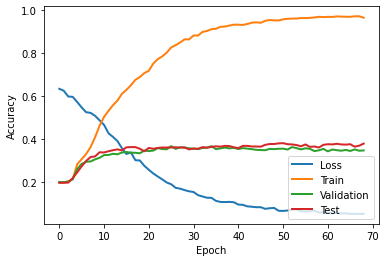

Best Validation Accuracy,  0.3683894230769231
Best Test Accuracy,  0.38232468780019213
0.38232468780019213 69


In [21]:
args.log_info = True

DATASET_NAME = 'Cora'
data, dataset = get_data(DATASET_NAME,DIR=None, log=False, h_score=True, split_no=0)
print(data)

channel = 'ht' #'all', 'hm', 'ht', 'sd'

# if DATASET_NAME in ['Squirrel', 'Chameleon']:
#     data.x = torch.cat((data.x, adj_feature(data)), dim=1)
#     if args.log_info == True:
#         print(data.x.shape)
    
best_acc, num_iteration, _ =  AGSGSperformanceSampler(DATASET_NAME, data, dataset, dataset.num_classes,
                                                      epochs=150, channel=channel)
print(best_acc, num_iteration)

# Batch Experiments

In [18]:
def batch_experiments(num_run=1, channel='all'):
    
    ALL_DATASETs= [
        "Roman-empire","Texas","Squirrel","Chameleon",
        "Cornell","Actor","Wisconsin","Flickr","Amazon-ratings","reed98","amherst41","genius",
        "AmazonProducts",
        "cornell5","penn94",
        "johnshopkins55",
        "Yelp",
        "cora","Tolokers","Minesweeper",
        "CiteSeer","Computers","PubMed","pubmed",
        "Reddit",
        "cora_ml","dblp",
        "Reddit2",
        "Cora","CS","Photo","Questions","Physics","citeseer",
    ]
    
    #ALL_DATASETs= ["Cora"]
    ALL_DATASETs= ["Squirrel"]
#     ALL_DATASETs= ["Texas", "Cornell", "Wisconsin"]
#     ALL_DATASETs= ["cornell5", "penn94", "johnshopkins55"]

    args.log_info = False
    
    filename = "Results/AGSGNN-SAINT-ACM-GS-"+channel+".txt"
    
    for DATASET_NAME in ALL_DATASETs:  
        print(DATASET_NAME, end=' ')
                
        result_file = open(filename,'a+')        
        result_file.write(f'{DATASET_NAME} ')
        result_file.close()
                
        accs = []
        itrs = []
                
        for i in range(num_run):
            data, dataset = get_data(DATASET_NAME, DIR=None, log=False, h_score=False, split_no=i)   
            
            if data.num_nodes>10000:
                accs.append(-1)
                itrs.append(-1)
                break
            
            if len(data.y.shape) > 1:
                data.y = data.y.argmax(dim=1)        
                num_classes = torch.max(data.y).item()+1
            else:
                num_classes = dataset.num_classes
            
            if num_classes!= torch.max(data.y)+1:
                num_classes = torch.max(data.y).item()+1
                
            if data.num_nodes<100000:
                max_epochs = 150
            else:
                max_epochs = 50
                
#             if DATASET_NAME in ['Squirrel', 'Chameleon', 
#                                 #'cornell5','penn94','johnshopkins55'
#                                ]:
#                 data.x = torch.cat((data.x, adj_feature(data)), dim=1)
#                 if args.log_info == True:
#                     print(data.x.shape)
                              
            accuracy, itr, _ = AGSGSperformanceSampler(DATASET_NAME, data, dataset, num_classes,epochs=max_epochs, channel=channel)
            
            accs.append(accuracy)
            itrs.append(itr)
            #print(itr, accuracy)
                        
        #print(accs, itrs)
        print(f'acc {np.mean(accs):0.4f} sd {np.std(accs):0.4f} itr {int(np.mean(itrs)):d} sd {int(np.std(itrs)):d}')
        result_file = open(filename,'a+')
        result_file.write(f'acc {np.mean(accs):0.4f} sd {np.std(accs):0.4f} itr {int(np.mean(itrs)):d} sd {int(np.std(itrs)):d}\n')
        result_file.close()
                
# start = time.time()
# batch_experiments(num_run=5, channel='ht')
# end = time.time()
# print("Time spent:", end-start)

## Visualize representation

In [19]:
if __name__ == '__main__':    
    
#     n=7
#     x = torch.Tensor([[1,0],[1,0],[1,0],[0,1],[0,1],[0,1],[0,1]])
#     y = torch.LongTensor([0,0,0, 1, 1, 1, 1])
#     edge_index = torch.LongTensor([[1,2],[1,4],[1,5],[2,1],[3,6],[3,7],[4,5],[4,1],[4,6],[4,7],[5,1],[5,4],[5,6],[6,3],[6,4],[6,5],[6,7],[7,3],[7,4],[7,6]]).T
#     edge_index = edge_index-1
    
#     mask = torch.zeros(n, dtype=torch.bool)
#     mask[[1,3]] = True
    
#     test_data = Data(x = x, y = y, edge_index = edge_index, train_mask = mask, test_mask = mask, val_mask = mask)    
#     print(test_data)
    
    
    None

In [20]:
# class AGS_layer(torch.nn.Module):
#     def __init__(self, input_channels, output_channels, dropout=0.2):
#         super().__init__()
#         self.T = 3
#         self.p = dropout
#         #self.Aconv1 = GCNConv(input_channels, output_channels)        
#         #self.Sconv1 = SpatialConv(input_channels, output_channels)
        
#         self.Aconv1 = GCNConv(input_channels, output_channels)
#         self.Sconv1 = SpatialConv(input_channels, output_channels)
        
#         self.I1 = nn.Linear(input_channels, output_channels)
        
#         self.layer_norm_a1 =  nn.LayerNorm(output_channels)
#         self.layer_norm_s1 =  nn.LayerNorm(output_channels)
#         self.layer_norm_i1 =  nn.LayerNorm(output_channels)
        
#         self.alpha_a1 = nn.Linear(output_channels, 1)
#         self.alpha_s1 = nn.Linear(output_channels, 1)
#         self.alpha_i1 = nn.Linear(output_channels, 1)
#         self.w1 = nn.Linear(3, 3)
        
#         #self.reset_parameters()
            
#     def reset_parameters(self):
        
#         stdv = 1. / math.sqrt(self.I1.weight.size(1))
#         std_att = 1. / math.sqrt(self.w1.weight.size(1))
#         std_att_vec = 1. / math.sqrt( self.alpha_a1.weight.size(1))
        
#         self.I1.weight.data.uniform_(-stdv, stdv)
        
#         self.alpha_a1.weight.data.uniform_(-std_att, std_att)
#         self.alpha_s1.weight.data.uniform_(-std_att, std_att)
#         self.alpha_i1.weight.data.uniform_(-std_att, std_att)
        
#         self.w1.weight.data.uniform_(-std_att_vec, std_att_vec)
        
#         self.layer_norm_a1.reset_parameters()
#         self.layer_norm_s1.reset_parameters()
#         self.layer_norm_i1.reset_parameters()
        

#     def forward(self, x0, edge_index, edge_weight=None):
#         a1 = F.relu(self.Aconv1(x0, edge_index, edge_weight))
#         a1 = self.layer_norm_a1(a1)
#         a1 = F.dropout(a1, p=self.p, training=self.training)
        
#         s1 = F.relu(self.Sconv1(x0, edge_index, edge_weight))
#         s1 = self.layer_norm_s1(s1)
#         s1 = F.dropout(s1, p=self.p, training=self.training)

#         i1 = F.relu(self.I1(x0))
#         i1 = self.layer_norm_i1(i1)
#         i1 = F.dropout(i1, p=self.p, training=self.training)
        
#         ala1 = torch.sigmoid(self.alpha_a1(a1))
#         als1 = torch.sigmoid(self.alpha_s1(s1))
#         ali1 = torch.sigmoid(self.alpha_i1(i1))        
#         alpha1 = F.softmax(self.w1(torch.cat([ala1, als1, ali1],dim=-1)/self.T), dim=1)        
        
#         x1 = torch.mm(torch.diag(alpha1[:,0]),a1) + torch.mm(torch.diag(alpha1[:,1]),s1) + torch.mm(torch.diag(alpha1[:,2]),i1)                
        
#         return x1
        
# class AGS_GCN(torch.nn.Module):
#     def __init__(self, num_features, num_classes, hidden_channels=16, dropout=0.2):
#         super().__init__()        
#         self.num_classes = num_classes
#         self.p = dropout
        
#         self.ags_layer1 = AGS_layer(num_features, hidden_channels)
#         self.ags_layer2 = AGS_layer(hidden_channels, hidden_channels)
#         #self.ags_layer2 = AGS_layer(hidden_channels, num_classes)
                
#         self.CombineW = nn.Linear(2 * hidden_channels, hidden_channels)
#         self.PredW = nn.Linear(1*hidden_channels, num_classes)
        
    
#     def forward(self, x0, edge_index, edge_weight=None):
        
#         #x0 = F.dropout(x0, p=self.p, training=self.training)
#         x1 = self.ags_layer1(x0, edge_index, edge_weight)
#         x1 = F.dropout(x1, p=self.p, training=self.training)
        
#         x2 = self.ags_layer2(x1, edge_index, edge_weight)
#         x2 = F.dropout(x2, p=self.p, training=self.training)        
        
#         #x = self.PredW(torch.cat([x1, x2], dim=-1))
#         x = self.PredW(x2)
         
#         #return x
#         return x.log_softmax(dim=-1)